# Import packages.

In [2]:
import sys
from pathlib import Path

# Ensure repository root is on sys.path so `notebooks.utils` is importable
repo_root = Path.cwd().resolve()
for candidate in (repo_root, *repo_root.parents):
    if (candidate / "notebooks" / "utils" / "load_training_data.py").exists():
        repo_root = candidate
        break
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

In [61]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import math
from typing import Optional, Iterable, Sequence, Mapping, Dict, Union, Callable, MutableMapping, MutableSequence

from notebooks.utils.load_training_data import load_training_results
from notebooks.utils.merge_neural_behavioral import merge_behavioral_and_neural

# Load training data.

### Baseline behavioral alignment results


In [ ]:
# Baseline Seed 1 Behavioral Alignment Results
baseline_seed1_ba_results = load_training_results(
    Path("../../data/training_results/baseline/training_res_seed1.csv"),
    truncate_at_min_test_loss=True,
)

# Baseline Seed 2 Behavioral Alignment Results
baseline_seed2_ba_results = load_training_results(
    Path("../../data/training_results/baseline/training_res_seed2.csv"),
    truncate_at_min_test_loss=True,
)

# Baseline Seed 3 Behavioral Alignment Results
baseline_seed3_ba_results = load_training_results(
    Path("../../data/training_results/baseline/training_res_seed3.csv"),
    truncate_at_min_test_loss=True,
)

### Baseline THINGS neural alignment results

In [ ]:
# Baseline Seed 1 THINGS Neural Alignment Results
baseline_seed1_things_na_results = pd.read_csv('../../data/brain_rsa_results/baseline/things/things_baseline_seed1_brain_rsa_results.csv')

# Baseline Seed 2 THINGS Neural Alignment Results
baseline_seed2_things_na_results = pd.read_csv('../../data/brain_rsa_results/baseline/things/things_baseline_seed2_brain_rsa_results.csv')

# Baseline Seed 3 THINGS Neural Alignment Results
baseline_seed3_things_na_results = pd.read_csv('../../data/brain_rsa_results/baseline/things/things_baseline_seed3_brain_rsa_results.csv')

### Merge the baseline behavioral alignment results with the baseline THINGS neural alignment results.

In [39]:
## Merge the baseline behavioral alignment results with the baseline THINGS neural alignment results.

# Baseline Seed 1
baseline_seed1_things_df = merge_behavioral_and_neural(baseline_seed1_ba_results, baseline_seed1_things_na_results)

# Baseline Seed 2
baseline_seed2_things_df = merge_behavioral_and_neural(baseline_seed2_ba_results, baseline_seed2_things_na_results)

# Baseline Seed 3
baseline_seed3_things_df = merge_behavioral_and_neural(baseline_seed3_ba_results, baseline_seed3_things_na_results)

### Single-epoch perturbation behavioral alignment results

In [40]:
# Single-epoch perturbation seed 1
sweep_seed1_ba_results = load_training_results(
    Path("/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/single_epoch_perturbation_sweeps/perturb_sweep_baselineseed1_perturbseed42"),
    multiple_files=True,
)

# Single-epoch perturbation seed 2
sweep_seed2_ba_results = load_training_results(
    Path("/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/single_epoch_perturbation_sweeps/perturb_sweep_baselineseed2_perturbseed43"),
    multiple_files=True,
)

# Single-epoch perturbation seed 3
sweep_seed3_ba_results = load_training_results(
    Path("/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/single_epoch_perturbation_sweeps/perturb_sweep_baselineseed3_perturbseed44"),
    multiple_files=True,
)

### Single-epoch perturbation neural alignment results

In [59]:
sweep_seed1_things_neural_results = pd.read_csv(
    repo_root
    / "data"
    / "brain_rsa_results"
    / "single_epoch_sweep"
    / "things"
    / "things_sweep_seed42_brain_rsa_results.csv"
)

# Define plotting functions.

### Behavioral-alignment-vs-test-loss curve

In [ ]:
# Define a function to plot the behavioral-alignment-vs-test-loss curve
def plot_behavior_vs_loss(
    df: pd.DataFrame,
    *,
    label_epochs: Sequence[int] = (1, 5, 10, 15, 98),
    ax: plt.Axes | None = None,
    line_kwargs: Mapping[str, float] | None = None,
) -> plt.Axes:
    """
    Plot the behavioral-alignment-vs-test-loss S-curve used throughout the analysis notebook.

    Parameters
    ----------
    df:
        DataFrame containing at least `epoch`, `test_loss`, and `behavioral_rsa_rho`.
        The rows should appear in chronological order.
    label_epochs:
        Iterable of epoch numbers to annotate on the curve.
    ax:
        Existing matplotlib axis to draw on. A new axis is created when omitted.
    line_kwargs:
        Additional keyword arguments forwarded to `Axes.plot`.

    Returns
    -------
    matplotlib.axes.Axes
        The axis containing the rendered plot.
    """
    plt.rcParams['font.family'] = 'Times New Roman'
    
    required_columns = {"epoch", "test_loss", "behavioral_rsa_rho"}
    missing = required_columns - set(df.columns)
    if missing:
        missing_str = ", ".join(sorted(missing))
        raise ValueError(f"DataFrame missing required columns: {missing_str}")

    ax = ax or plt.gca()
    line_kwargs = {"linewidth": 0.8, "color": "black", **(line_kwargs or {})}
    color = line_kwargs["color"]

    ax.plot(df["test_loss"], df["behavioral_rsa_rho"], **line_kwargs)

    for epoch in label_epochs:
        match = df[df["epoch"] == epoch]
        if match.empty:
            continue
        x = match["test_loss"].iloc[0]
        y = match["behavioral_rsa_rho"].iloc[0]

        if epoch == label_epochs[0]:
            label_x = x
            label_y = y + 0.05
            ha = "left"
        else:
            label_x = x + 7
            label_y = y + 0.02
            ha = "right"

        ax.text(label_x, label_y, f"epoch {epoch}", fontsize=7, ha=ha, va="bottom")
        ax.plot([x, label_x], [y, label_y], color=color, linewidth=0.7, zorder=2)

    ax.invert_xaxis()
    ax.set_xlabel("Test Loss", fontweight="bold", fontsize=14)
    ax.set_ylabel("Behavioral\nAlignment", fontweight="bold", fontsize=14)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    xmin, xmax = ax.get_xlim()
    step = 20
    if xmin > xmax:
        start = int(np.ceil(xmin / step) * step)
        stop = int(np.floor(xmax / step) * step) - step
        xticks = np.arange(start, stop - step, -step)
    else:
        start = int(np.floor(xmin / step) * step)
        stop = int(np.ceil(xmax / step) * step) + step
        xticks = np.arange(start, stop + step, step)
    ax.set_xticks(xticks)

    return ax

### Neural-alignment-vs-test-loss curve

In [22]:
# Define a function to plot the neural-alignment-vs-test-loss curve
def plot_neural_alignment_vs_loss(
    df: pd.DataFrame,
    *,
    roi_order: Optional[Iterable[str]] = None,
    plot_rois: Optional[Iterable[str]] = None,
    label_rois: Optional[Iterable[str]] = None,
    ax: Optional[plt.Axes] = None,
    line_kwargs: Optional[Mapping[str, Mapping[str, float]]] = None,
    label_offsets: Optional[Mapping[str, Dict[str, float]]] = None,
    legend_title: str = "ROI",
    xtick_step: int = 20,
) -> plt.Axes:
    """
    Plot neural RSA alignment (rho) versus test loss for multiple ROIs.

    Parameters
    ----------
    df:
        DataFrame containing columns `roi`, `test_loss`, `rho`, and `epoch`.
    roi_order:
        Optional iterable describing the order in which ROIs are plotted. Defaults
        to the alphabetical order present in the DataFrame.
    plot_rois:
        Optional iterable specifying which ROIs to include in the figure. All ROIs
        are plotted when omitted.
    label_rois:
        Optional iterable of ROI names to label directly on the plot. Other ROIs
        will appear only in the legend.
    ax:
        Existing matplotlib axis; a new axis is created if omitted.
    line_kwargs:
        Mapping from ROI name to keyword arguments forwarded to `Axes.plot`.
        A fallback style (linewidth=0.8) is used when an ROI is missing.
    label_offsets:
        Mapping from ROI name to dicts with optional `dx`/`dy` adjustments for the
        annotation position.
    legend_title:
        Title shown above the ROI legend.
    xtick_step:
        Spacing between x-axis tick marks (after inversion).

    Returns
    -------
    matplotlib.axes.Axes
        Axis containing the rendered neural-alignment curve(s).
    """
    plt.rcParams['font.family'] = 'Times New Roman'
    
    required_columns = {"roi", "test_loss", "rho"}
    missing = required_columns - set(df.columns)
    if missing:
        missing_str = ", ".join(sorted(missing))
        raise ValueError(f"DataFrame missing required columns: {missing_str}")

    plot_rois_set = set(plot_rois) if plot_rois is not None else None
    plot_df = (
        df[df["roi"].isin(plot_rois_set)].copy()
        if plot_rois_set is not None
        else df.copy()
    )

    if plot_df.empty:
        raise ValueError("No rows available after applying the `plot_rois` filter.")

    ax = ax or plt.gca()
    available_rois = sorted(plot_df["roi"].unique())
    roi_order = list(roi_order) if roi_order is not None else available_rois
    if plot_rois_set is not None:
        roi_order = [roi for roi in roi_order if roi in plot_rois_set]
    roi_order = [roi for roi in roi_order if roi in available_rois]

    label_rois = set(label_rois) if label_rois is not None else set()
    if label_rois:
        label_rois &= set(available_rois)
    label_offsets = label_offsets or {}

    handles: MutableSequence[plt.Line2D] = []
    labels: MutableSequence[str] = []

    for roi in roi_order:
        roi_df = plot_df[plot_df["roi"] == roi]
        if roi_df.empty:
            continue

        defaults = {"linewidth": 0.8}
        roi_kwargs = {**defaults, **(line_kwargs.get(roi, {}) if line_kwargs else {})}
        (line,) = ax.plot(roi_df["test_loss"], roi_df["rho"], **roi_kwargs)

        if roi in label_rois:
            # Use the last point (closest to min test loss) for labeling.
            x = roi_df["test_loss"].iloc[-1]
            y = roi_df["rho"].iloc[-1]
            offsets = label_offsets.get(roi, {})
            dx = offsets.get("dx", -5)
            dy = offsets.get("dy", 0.0)

            ax.text(
                x + dx,
                y + dy,
                roi,
                color=line.get_color(),
                ha="center",
                fontsize=10,
                fontweight="bold",
                bbox=dict(facecolor="white", edgecolor="none", pad=0.2, alpha=0.7),
            )
        else:
            handles.append(line)
            labels.append(roi)

    if handles and labels:
        legend = ax.legend(
            handles,
            labels,
            title=legend_title,
            fontsize=7,
            title_fontsize=8,
        )
        for legline in legend.get_lines():
            legline.set_linewidth(1.5)

    ax.set_xlabel("Test Loss", fontweight="bold", fontsize=14)
    ax.set_ylabel("Neural Alignment", fontweight="bold", fontsize=14)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.invert_xaxis()

    xmin, xmax = ax.get_xlim()
    if xmin > xmax:
        start = int(np.ceil(xmin / xtick_step) * xtick_step)
        stop = int(np.floor(xmax / xtick_step) * xtick_step) - xtick_step
        xticks = np.arange(start, stop - xtick_step, -xtick_step)
    else:
        start = int(np.floor(xmin / xtick_step) * xtick_step)
        stop = int(np.ceil(xmax / xtick_step) * xtick_step) + xtick_step
        xticks = np.arange(start, stop + xtick_step, xtick_step)
    ax.set_xticks(xticks)

    return ax

### Single-epoch delta behavioral alignment compared to baseline

In [53]:
__all__ = ["plot_single_epoch_delta_behavioral_alignment"]

EpochParser = Callable[[str], int]

def _infer_epoch_from_name(run_name: str) -> int:
    """Best-effort parser that extracts the trailing integer from a run name."""
    digits = re.findall(r"\d+", run_name)
    if not digits:
        raise ValueError(
            "Unable to infer perturbation epoch from run name "
            f"'{run_name}'. Provide `perturbation_epochs` or `epoch_parser`."
        )
    return int(digits[-1])


def plot_single_epoch_delta_behavioral_alignment(
    baseline_df: pd.DataFrame,
    perturbed_runs: Mapping[str, pd.DataFrame],
    *,
    value_column: str = "behavioral_rsa_rho",
    perturbation_epochs: Mapping[str, int] | None = None,
    epoch_parser: EpochParser | None = None,
    ax: plt.Axes | None = None,
    title: str | None = None,
    positive_color: str = "green",
    negative_color: str = "blue",
    zero_color: str = "#7f8c8d",
    bar_kwargs: Mapping[str, float] | None = None,
) -> tuple[plt.Axes, pd.DataFrame]:
    """
    Plot perturbation-induced delta in behavioral alignment for single-epoch sweeps.

    Parameters
    ----------
    baseline_df:
        DataFrame containing the unperturbed training metrics with columns
        `epoch` and the column indicated by `value_column`.
    perturbed_runs:
        Mapping from run identifier to DataFrame that includes `epoch` and the
        behavioral-alignment column. Each run corresponds to a perturbation
        applied at a single epoch.
    value_column:
        Column name containing the behavioral-alignment metric (defaults to
        `behavioral_rsa_rho` to match the analysis notebook).
    perturbation_epochs:
        Optional mapping specifying the perturbation epoch for each run. When
        omitted, `epoch_parser` (or the built-in parser) is used to infer the
        epoch from the run name.
    epoch_parser:
        Callable that receives a run name and returns the perturbation epoch,
        used only when `perturbation_epochs` does not provide a value.
    ax:
        Existing matplotlib axis to draw on; a new axis is created when omitted.
    title:
        Optional plot title.
    positive_color / negative_color / zero_color:
        Bar colors used for positive, negative, and zero deltas respectively.
    bar_kwargs:
        Additional keyword arguments forwarded to `Axes.bar`.

    Returns
    -------
    (matplotlib.axes.Axes, pandas.DataFrame)
        The rendered axis and a DataFrame summarizing the delta behavioral
        alignment per perturbation epoch.
    """

    plt.rcParams["font.family"] = "Times New Roman"

    baseline_required = {"epoch", value_column}
    missing = baseline_required - set(baseline_df.columns)
    if missing:
        missing_str = ", ".join(sorted(missing))
        raise ValueError(
            f"Baseline DataFrame missing required columns: {missing_str}"
        )

    epoch_lookup: MutableMapping[str, int] = (
        {k: int(v) for k, v in (perturbation_epochs or {}).items()}
    )
    parser = epoch_parser or _infer_epoch_from_name

    records: list[dict[str, float | int | str]] = []

    for run_name, df in perturbed_runs.items():
        if df is None or df.empty:
            continue

        missing = baseline_required - set(df.columns)
        if missing:
            missing_str = ", ".join(sorted(missing))
            raise ValueError(
                f"Run '{run_name}' is missing required columns: {missing_str}"
            )

        if run_name in epoch_lookup:
            perturb_epoch = epoch_lookup[run_name]
        else:
            try:
                perturb_epoch = parser(run_name)
            except Exception as exc:  # pragma: no cover - defensive
                raise ValueError(
                    "Failed to infer perturbation epoch for run "
                    f"'{run_name}'. Supply `perturbation_epochs` explicitly."
                ) from exc

        run_point = df[df["epoch"] == perturb_epoch]
        baseline_point = baseline_df[baseline_df["epoch"] == perturb_epoch]

        if run_point.empty or baseline_point.empty:
            continue

        run_value = float(run_point[value_column].iloc[0])
        baseline_value = float(baseline_point[value_column].iloc[0])
        delta = run_value - baseline_value

        records.append(
            {
                "run_name": run_name,
                "perturbation_epoch": perturb_epoch,
                "delta_behavioral_alignment": delta,
                "perturbed_behavioral_alignment": run_value,
                "baseline_behavioral_alignment": baseline_value,
            }
        )

    if not records:
        raise ValueError(
            "No overlapping epochs between the baseline and perturbed runs. "
            "Ensure that the inputs contain matching epoch values."
        )

    delta_df = pd.DataFrame(records).sort_values("perturbation_epoch")
    ax = ax or plt.gca()

    bar_defaults = {"alpha": 0.7, "edgecolor": "black", "linewidth": 0.5}
    bar_opts = {**bar_defaults, **(bar_kwargs or {})}

    colors: Sequence[str] = [
        positive_color if delta > 0 else negative_color if delta < 0 else zero_color
        for delta in delta_df["delta_behavioral_alignment"]
    ]

    ax.bar(
        delta_df["perturbation_epoch"],
        delta_df["delta_behavioral_alignment"],
        color=colors,
        **bar_opts,
    )

    ax.axhline(0, color="black", linestyle="-", linewidth=1, alpha=0.8)
    ax.grid(True, linestyle="--", axis="y", alpha=0.3)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlabel("Perturbation Epoch", fontweight="bold", fontsize=14)
    ax.set_ylabel(r"$\Delta$ Behavioral Alignment", fontweight="bold", fontsize=14)
    if title:
        ax.set_title(title, fontsize=14, fontweight="bold")
    ax.tick_params(axis="both", labelsize=12)

    return ax

### Single-epoch delta test loss compared to baseline

In [48]:
def plot_single_epoch_delta_test_loss(
    baseline_df: pd.DataFrame,
    perturbed_runs: Mapping[str, pd.DataFrame],
    *,
    perturbation_epochs: Mapping[str, int] | None = None,
    epoch_parser: EpochParser | None = None,
    ax: plt.Axes | None = None,
    title: str | None = None,
    positive_color: str = "red",
    negative_color: str = "#green",
    zero_color: str = "#7f8c8d",
    bar_kwargs: Mapping[str, float] | None = None,
) -> tuple[plt.Axes, pd.DataFrame]:
    """
    Plot the perturbation-induced delta in test loss for single-epoch sweeps.

    Parameters
    ----------
    baseline_df:
        DataFrame containing the unperturbed training metrics with columns
        `epoch` and `test_loss`.
    perturbed_runs:
        Mapping from run identifier to DataFrame that includes `epoch` and
        `test_loss`. Each run corresponds to a perturbation applied at a single
        epoch.
    perturbation_epochs:
        Optional mapping specifying the perturbation epoch for each run. When
        omitted, `epoch_parser` (or the built-in parser) is used to infer the
        epoch from the run name.
    epoch_parser:
        Callable that receives a run name and returns the perturbation epoch,
        used only when `perturbation_epochs` does not provide a value.
    ax:
        Existing matplotlib axis to draw on; a new axis is created when omitted.
    title:
        Optional plot title.
    positive_color / negative_color / zero_color:
        Bar colors used for positive, negative, and zero deltas respectively.
    bar_kwargs:
        Additional keyword arguments forwarded to `Axes.bar`.

    Returns
    -------
    (matplotlib.axes.Axes, pandas.DataFrame)
        The rendered axis and a DataFrame summarizing the delta test loss per
        perturbation epoch.
    """

    plt.rcParams["font.family"] = "Times New Roman"

    required_cols = {"epoch", "test_loss"}
    missing = required_cols - set(baseline_df.columns)
    if missing:
        missing_str = ", ".join(sorted(missing))
        raise ValueError(
            f"Baseline DataFrame missing required columns: {missing_str}"
        )

    epoch_lookup: MutableMapping[str, int] = (
        {k: int(v) for k, v in (perturbation_epochs or {}).items()}
    )
    parser = epoch_parser or _infer_epoch_from_name

    records: list[dict[str, float | int | str]] = []

    for run_name, df in perturbed_runs.items():
        if df is None or df.empty:
            continue

        missing = required_cols - set(df.columns)
        if missing:
            missing_str = ", ".join(sorted(missing))
            raise ValueError(
                f"Run '{run_name}' is missing required columns: {missing_str}"
            )

        if run_name in epoch_lookup:
            perturb_epoch = epoch_lookup[run_name]
        else:
            try:
                perturb_epoch = parser(run_name)
            except Exception as exc:  # pragma: no cover - defensive
                raise ValueError(
                    "Failed to infer perturbation epoch for run "
                    f"'{run_name}'. Supply `perturbation_epochs` explicitly."
                ) from exc

        run_point = df[df["epoch"] == perturb_epoch]
        baseline_point = baseline_df[baseline_df["epoch"] == perturb_epoch]

        if run_point.empty or baseline_point.empty:
            continue

        run_loss = float(run_point["test_loss"].iloc[0])
        baseline_loss = float(baseline_point["test_loss"].iloc[0])
        delta = run_loss - baseline_loss

        records.append(
            {
                "run_name": run_name,
                "perturbation_epoch": perturb_epoch,
                "delta_test_loss": delta,
                "perturbed_test_loss": run_loss,
                "baseline_test_loss": baseline_loss,
            }
        )

    if not records:
        raise ValueError(
            "No overlapping epochs between the baseline and perturbed runs. "
            "Ensure that the inputs contain matching epoch values."
        )

    delta_df = pd.DataFrame(records).sort_values("perturbation_epoch")
    ax = ax or plt.gca()

    bar_defaults = {"alpha": 0.7, "edgecolor": "black", "linewidth": 0.5}
    bar_opts = {**bar_defaults, **(bar_kwargs or {})}

    colors: Sequence[str] = [
        positive_color if delta > 0 else negative_color if delta < 0 else zero_color
        for delta in delta_df["delta_test_loss"]
    ]

    ax.bar(
        delta_df["perturbation_epoch"],
        delta_df["delta_test_loss"],
        color=colors,
        **bar_opts,
    )

    ax.axhline(0, color="black", linestyle="-", linewidth=1, alpha=0.8)
    ax.grid(True, linestyle="--", axis="y", alpha=0.3)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlabel("Perturbation Epoch", fontweight="bold", fontsize=14)
    ax.set_ylabel(r"$\Delta$ Test Loss", fontweight="bold", fontsize=14)
    if title:
        ax.set_title(title, fontsize=14, fontweight="bold")
    ax.tick_params(axis="both", labelsize=12)

    return ax

### Single-epoch delta neural alignment compared to baseline

In [57]:
def plot_single_epoch_delta_neural_alignment(
    baseline_df: pd.DataFrame,
    perturbed_runs: Union[Mapping[str, pd.DataFrame], pd.DataFrame],
    *,
    roi_column: str = "roi",
    value_column: str = "rho",
    perturbed_runs_is_mapping: bool = True,
    training_run_column: str = "training_run",
    perturbation_epochs: Mapping[str, int] | None = None,
    epoch_parser: EpochParser | None = None,
    ax: plt.Axes | None = None,
    title: str | None = None,
    positive_color: str = "#2c7bb6",
    negative_color: str = "#d7191c",
    zero_color: str = "#7f8c8d",
    bar_kwargs: Mapping[str, float] | None = None,
    plot_rois: Sequence[str] | None = None,
) -> tuple[
    Union[plt.Axes, plt.Figure],
    Union[pd.DataFrame, Mapping[str, pd.DataFrame]],
]:
    """
    Plot perturbation-induced delta in neural alignment for single-epoch sweeps.

    Parameters
    ----------
    baseline_df:
        DataFrame containing the unperturbed neural RSA metrics with columns
        `epoch`, `training_run`, `roi`, and the column indicated by `value_column`.
    perturbed_runs:
        Either a mapping from run identifier to DataFrame (each containing `epoch`,
        `training_run`, `roi`, and the neural-alignment column) or a single DataFrame
        that includes all perturbation runs with a `training_run` column.
    roi_column:
        Column containing ROI labels (defaults to `roi`).
    value_column:
        Column containing the neural alignment metric (defaults to `rho`).
    perturbed_runs_is_mapping:
        When True (default), `perturbed_runs` must be a mapping. When False, a single
        DataFrame is expected and runs are separated via `training_run_column`.
    training_run_column:
        Column name identifying runs inside `perturbed_runs` when
        `perturbed_runs_is_mapping=False`.
    perturbation_epochs:
        Optional mapping specifying the perturbation epoch for each run. When
        omitted, `epoch_parser` (or the built-in parser) is used to infer the
        epoch from the run name.
    epoch_parser:
        Callable that receives a run name and returns the perturbation epoch,
        used only when `perturbation_epochs` does not provide a value.
    ax:
        Existing matplotlib axis to draw on; a new axis is created when omitted.
    title:
        Optional plot title.
    positive_color / negative_color / zero_color:
        Bar colors used for positive, negative, and zero deltas respectively.
    bar_kwargs:
        Additional keyword arguments forwarded to `Axes.bar`.
    plot_rois:
        Optional iterable of ROI names to include when computing the delta. All ROIs
        are used when omitted.

    Returns
    -------
    tuple
        When a single ROI (or no ROI filter) is used, returns `(Axes, DataFrame)`
        describing the delta averaged across the selected ROIs. When
        `plot_rois` contains multiple ROIs, returns `(Figure, Dict[str, DataFrame])`
        where each subplot visualizes one ROI and the dictionary stores the
        underlying per-ROI delta values.
    """

    plt.rcParams["font.family"] = "Times New Roman"

    if plot_rois is not None:
        roi_order = list(dict.fromkeys(plot_rois))
        if not roi_order:
            raise ValueError("`plot_rois` must contain at least one ROI name.")
        roi_filter_set = set(roi_order)
    else:
        roi_order = None
        roi_filter_set = None
    multi_roi = roi_filter_set is not None and len(roi_filter_set) > 1

    required_cols = {"epoch", roi_column, value_column}
    missing = required_cols - set(baseline_df.columns)
    if missing:
        missing_str = ", ".join(sorted(missing))
        raise ValueError(
            f"Baseline DataFrame missing required columns: {missing_str}"
        )

    if roi_filter_set is not None:
        baseline_df = baseline_df[baseline_df[roi_column].isin(roi_filter_set)].copy()
        if baseline_df.empty:
            raise ValueError(
                "No baseline rows remain after applying the specified `plot_rois`."
            )

    epoch_lookup: MutableMapping[str, int] = (
        {k: int(v) for k, v in (perturbation_epochs or {}).items()}
    )
    parser = epoch_parser or _infer_epoch_from_name

    records: list[dict[str, float | int | str]] = []
    roi_records: dict[str, list[dict[str, float | int | str]]] = {}

    if multi_roi:
        baseline_roi_lookup = baseline_df.set_index([roi_column, "epoch"])[value_column]
        baseline_epoch_mean = None
    else:
        baseline_epoch_mean = (
            baseline_df.groupby("epoch")[value_column].mean().rename("baseline_mean")
        )
        baseline_roi_lookup = None

    if perturbed_runs_is_mapping:
        if not isinstance(perturbed_runs, Mapping):
            raise TypeError(
                "Expected `perturbed_runs` to be a mapping when "
                "`perturbed_runs_is_mapping=True`."
            )
        run_items = list(perturbed_runs.items())
    else:
        if isinstance(perturbed_runs, Mapping):
            raise TypeError(
                "Set `perturbed_runs_is_mapping=True` when passing a mapping of runs."
            )
        if not isinstance(perturbed_runs, pd.DataFrame):
            raise TypeError(
                "Expected `perturbed_runs` to be a pandas DataFrame when "
                "`perturbed_runs_is_mapping=False`."
            )
        if training_run_column not in perturbed_runs.columns:
            raise ValueError(
                f"Column '{training_run_column}' is required in `perturbed_runs` "
                "when `perturbed_runs_is_mapping=False`."
            )
        run_items = [
            (
                f"training_run{int(run_id)}",
                run_df.reset_index(drop=True),
            )
            for run_id, run_df in perturbed_runs.groupby(training_run_column)
        ]

    for run_name, df in run_items:
        if df is None or df.empty:
            continue

        missing = required_cols - set(df.columns)
        if missing:
            missing_str = ", ".join(sorted(missing))
            raise ValueError(
                f"Run '{run_name}' is missing required columns: {missing_str}"
            )

        if run_name in epoch_lookup:
            perturb_epoch = epoch_lookup[run_name]
        else:
            try:
                perturb_epoch = parser(run_name)
            except Exception as exc:  # pragma: no cover - defensive
                raise ValueError(
                    "Failed to infer perturbation epoch for run "
                    f"'{run_name}'. Supply `perturbation_epochs` explicitly."
                ) from exc

        run_at_epoch = df[df["epoch"] == perturb_epoch]
        if roi_filter_set is not None:
            run_at_epoch = run_at_epoch[run_at_epoch[roi_column].isin(roi_filter_set)]
        if run_at_epoch.empty:
            continue

        if multi_roi:
            grouped = run_at_epoch.groupby(roi_column)
            for roi, roi_rows in grouped:
                if roi_filter_set is not None and roi not in roi_filter_set:
                    continue
                roi_value = float(roi_rows[value_column].iloc[0])
                try:
                    baseline_value = float(
                        baseline_roi_lookup.loc[(roi, perturb_epoch)]
                    )
                except KeyError:
                    continue

                roi_records.setdefault(roi, []).append(
                    {
                        "run_name": run_name,
                        "perturbation_epoch": perturb_epoch,
                        "delta_neural_alignment": roi_value - baseline_value,
                        "perturbed_neural_alignment": roi_value,
                        "baseline_neural_alignment": baseline_value,
                    }
                )
        else:
            run_mean = run_at_epoch[value_column].mean()
            try:
                baseline_mean = baseline_epoch_mean.loc[perturb_epoch]
            except KeyError:
                continue

            delta = run_mean - float(baseline_mean)

            records.append(
                {
                    "run_name": run_name,
                    "perturbation_epoch": perturb_epoch,
                    "delta_neural_alignment": delta,
                    "perturbed_neural_alignment_mean": run_mean,
                    "baseline_neural_alignment_mean": float(baseline_mean),
                }
            )

    bar_defaults = {"alpha": 0.7, "edgecolor": "black", "linewidth": 0.5}
    bar_opts = {**bar_defaults, **(bar_kwargs or {})}

    if multi_roi:
        roi_order = roi_order or sorted(roi_records.keys())
        roi_delta_frames: dict[str, pd.DataFrame] = {}
        all_deltas: list[float] = []
        all_epochs: set[int] = set()

        for roi in roi_order:
            df_roi = pd.DataFrame(roi_records.get(roi, []))
            if not df_roi.empty:
                df_roi = df_roi.sort_values("perturbation_epoch")
                all_deltas.extend(df_roi["delta_neural_alignment"].tolist())
                all_epochs.update(df_roi["perturbation_epoch"].tolist())
            roi_delta_frames[roi] = df_roi

        if not all_deltas:
            raise ValueError(
                "No overlapping epochs between the baseline and perturbed runs for the specified ROIs."
            )

        global_ymin = min(all_deltas)
        global_ymax = max(all_deltas)
        if math.isclose(global_ymin, global_ymax):
            pad = 0.05 if math.isclose(global_ymin, 0.0) else abs(global_ymin) * 0.05
            global_ymin -= pad
            global_ymax += pad
        else:
            pad = 0.05 * (global_ymax - global_ymin)
            global_ymin -= pad
            global_ymax += pad

        xticks = sorted(all_epochs)
        n_rois = len(roi_order)
        n_cols = min(4, n_rois)
        n_rows = math.ceil(n_rois / n_cols)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
        if isinstance(axes, plt.Axes):
            axes_flat = [axes]
        elif hasattr(axes, "flat"):
            axes_flat = list(axes.flat)
        else:
            axes_flat = [axes]

        for idx, roi in enumerate(roi_order):
            ax_roi = axes_flat[idx]
            df_roi = roi_delta_frames.get(roi, pd.DataFrame())
            if not df_roi.empty:
                colors = [
                    positive_color
                    if val > 0
                    else negative_color
                    if val < 0
                    else zero_color
                    for val in df_roi["delta_neural_alignment"]
                ]
                ax_roi.bar(
                    df_roi["perturbation_epoch"],
                    df_roi["delta_neural_alignment"],
                    color=colors,
                    **bar_opts,
                )
                ax_roi.axhline(0, color="black", linestyle="--", linewidth=0.8, alpha=0.6)
                if xticks:
                    ax_roi.set_xticks(xticks)
                if xticks:
                    ax_roi.set_xlim(min(xticks) - 0.5, max(xticks) + 0.5)
                ax_roi.set_ylim(global_ymin, global_ymax)
                ax_roi.set_xlabel("Perturbation Epoch", fontweight="bold", fontsize=11)
                ax_roi.set_ylabel(r"$\Delta$ Neural Alignment", fontweight="bold", fontsize=11)
                ax_roi.set_title(roi, fontweight="bold", fontsize=14)
                ax_roi.grid(True, linestyle="--", axis="y", alpha=0.3)
                ax_roi.tick_params(axis="both", labelsize=10)
                ax_roi.spines["top"].set_visible(False)
                ax_roi.spines["right"].set_visible(False)
            else:
                ax_roi.text(
                    0.5,
                    0.5,
                    f"No data for {roi}",
                    transform=ax_roi.transAxes,
                    ha="center",
                    va="center",
                    fontsize=12,
                )
                ax_roi.set_axis_off()

        for idx in range(n_rois, len(axes_flat)):
            axes_flat[idx].set_visible(False)

        if title:
            fig.suptitle(title, fontweight="bold", fontsize=16, y=0.98)
            fig.tight_layout()
            fig.subplots_adjust(top=0.9)
        else:
            fig.tight_layout()

        return fig, roi_delta_frames

    if not records:
        raise ValueError(
            "No overlapping epochs between the baseline and perturbed runs. "
            "Ensure that the inputs contain matching epoch values."
        )

    delta_df = pd.DataFrame(records).sort_values("perturbation_epoch")
    ax = ax or plt.gca()

    colors: Sequence[str] = [
        positive_color if delta > 0 else negative_color if delta < 0 else zero_color
        for delta in delta_df["delta_neural_alignment"]
    ]

    ax.bar(
        delta_df["perturbation_epoch"],
        delta_df["delta_neural_alignment"],
        color=colors,
        **bar_opts,
    )

    ax.axhline(0, color="black", linestyle="-", linewidth=1, alpha=0.8)
    ax.grid(True, linestyle="--", axis="y", alpha=0.3)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlabel("Perturbation Epoch", fontweight="bold", fontsize=14)
    ax.set_ylabel(r"$\Delta$ Neural Alignment (mean ROI)", fontweight="bold", fontsize=14)
    if title:
        ax.set_title(title, fontsize=14, fontweight="bold")
    ax.tick_params(axis="both", labelsize=12)

    return ax, delta_df.reset_index(drop=True)

# Figure 2

### Effects of different  perturbation types

# Figure 3

### Baseline behavioral & neural alignment

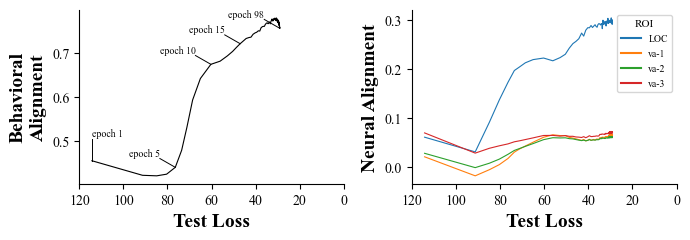

In [31]:
# Example: side-by-side behavioral vs neural alignment
fig, axes = plt.subplots(1, 2, figsize=(7, 2.5), sharey=False)

# Left: behavioral alignment vs loss
plot_behavior_vs_loss(
    baseline_seed1_ba_results,  # or whichever df you want
    ax=axes[0],
)

# Right: neural alignment vs loss
plot_neural_alignment_vs_loss(
    baseline_seed1_things_df,   # replace with your neural DataFrame
    ax=axes[1]
)

plt.tight_layout()
plt.show()

# Figure 4(A)

### Change in behavioral alignment at single-epoch perturbations

<Axes: xlabel='Perturbation Epoch', ylabel='$\\Delta$ Behavioral Alignment'>

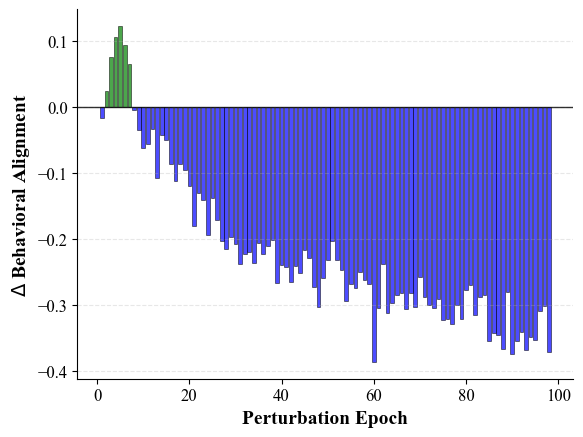

In [54]:
plot_single_epoch_delta_behavioral_alignment(baseline_seed1_ba_results, sweep_seed1_ba_results)

# Figure 4(B)

<Axes: xlabel='Perturbation Epoch', ylabel='$\\Delta$ Test Loss'>

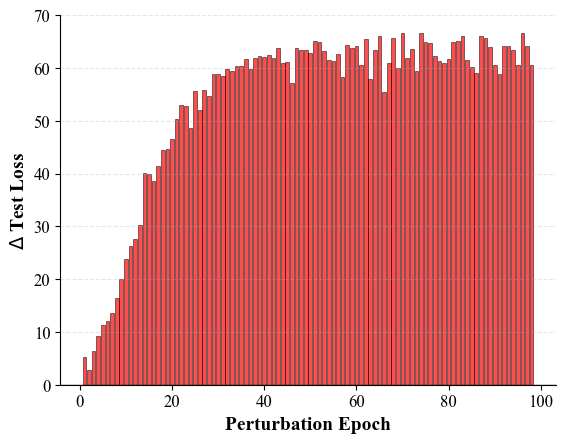

In [50]:
plot_single_epoch_delta_test_loss(baseline_seed1_ba_results, sweep_seed1_ba_results)

### Figure 4(C)

(<Figure size 1600x300 with 4 Axes>,
 {'LOC':           run_name  perturbation_epoch  delta_neural_alignment  \
  0    training_run1                   1               -0.019862   
  1    training_run2                   2               -0.008189   
  2    training_run3                   3               -0.030272   
  3    training_run4                   4               -0.055122   
  4    training_run5                   5               -0.088448   
  ..             ...                 ...                     ...   
  92  training_run94                  94               -0.204942   
  93  training_run95                  95               -0.185906   
  94  training_run96                  96               -0.188401   
  95  training_run97                  97               -0.184414   
  96  training_run98                  98               -0.196919   
  
      perturbed_neural_alignment  baseline_neural_alignment  
  0                     0.040813                   0.060676  
  1          

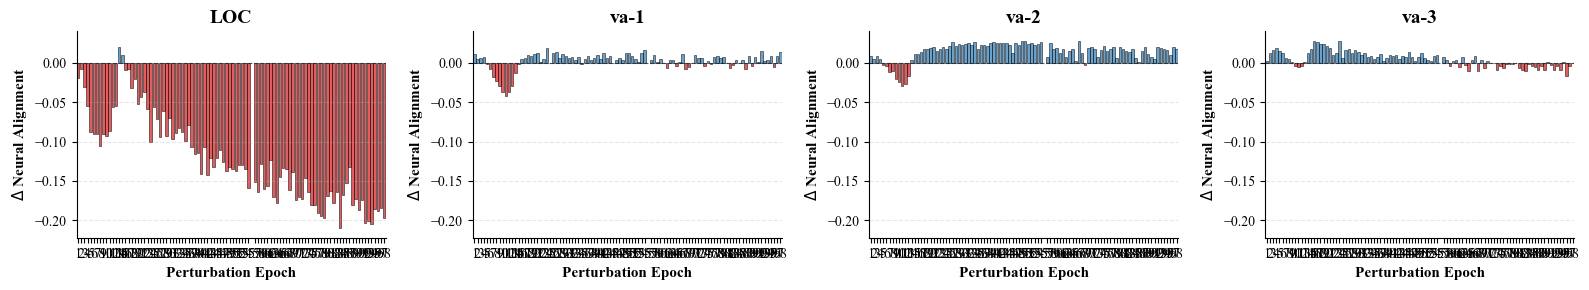

In [62]:
plot_single_epoch_delta_neural_alignment(
    baseline_seed1_things_df,
    sweep_seed1_things_neural_results,
    perturbed_runs_is_mapping=False,
    plot_rois=['LOC', 'va-1', 'va-2', 'va-3']
)

# Supplementary Figures

### Baseline Behavioral Alignment - Seed 2

<Axes: xlabel='Test Loss', ylabel='Behavioral\nAlignment'>

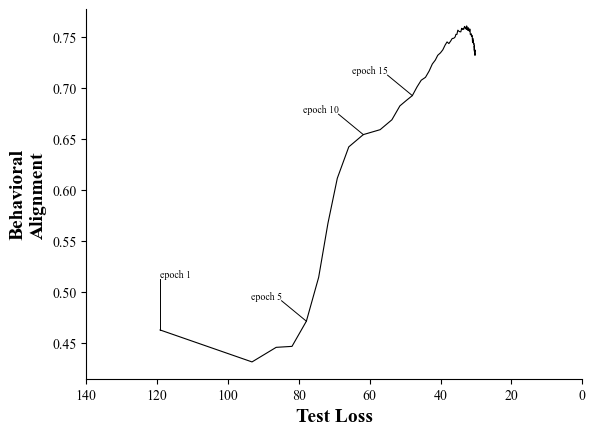

In [15]:
plot_behavior_vs_loss(baseline_seed2_ba_results)

### Baseline Behavioral Alignment - Seed 2

<Axes: xlabel='Test Loss', ylabel='Behavioral\nAlignment'>

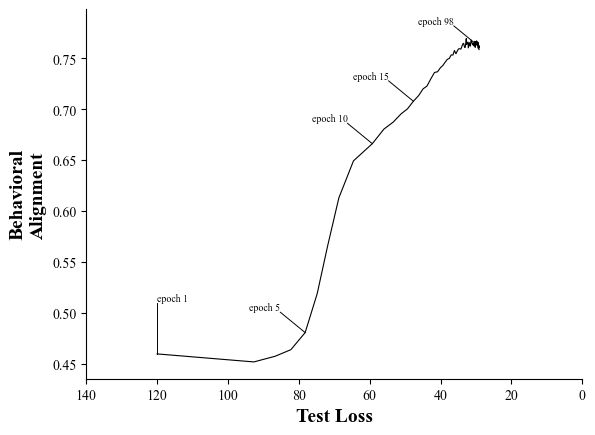

In [16]:
plot_behavior_vs_loss(baseline_seed3_ba_results)